# Inspired by
https://www.kaggle.com/code/venkatkrishnan/simple-nlp-topic-modeling-approach-multiclass

https://www.kaggle.com/code/nidhitalwar/83-26-research-topic-prediction

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from gensim.parsing.preprocessing import (
    preprocess_string,
    strip_tags,
    strip_punctuation,
    remove_stopwords,
    strip_multiple_whitespaces
)
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfTransformer, HashingVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Read data from files

In [3]:
train_df = pd.read_parquet('./data/cc_data.parquet')
test_df = pd.read_parquet('./data/cc_test.parquet')

# explore data

In [4]:
train_df.columns

Index(['TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

In [5]:
print(train_df.isnull().sum())
print(train_df.columns)

TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64
Index(['TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [6]:
train_df.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Characterization of multivariate Bernoulli dis...,We express each Fréchet class of multivariat...,0,0,1,1,0,0
1,Distinction of representations via Bruhat-Tits...,Introductory and pedagogical treatmeant of t...,0,0,1,0,0,0
2,"On the origin of the shallow and ""replica"" ban...",We compare electronic structures of single F...,0,1,0,0,0,0
3,Explaining Recurrent Neural Network Prediction...,"Recently, a technique called Layer-wise Rele...",1,0,0,1,0,0
4,Estimators of the correlation coefficient in t...,A finite-support constraint on the parameter...,0,0,0,1,0,0


In [7]:
test_df.head()

,TITLE,ABSTRACT
0,"Testing SPARUS II AUV, an open platform for in...",This paper describes the experience of prepa...
1,Recent progress on conditional randomness,"In this article, recent progress on ML-rando..."
2,FADE: Fast and Asymptotically efficient Distri...,Consider a set of agents that wish to estima...
3,How Wrong Am I? - Studying Adversarial Example...,Machine learning models are vulnerable to Ad...
4,Topological conjugacy of topological Markov sh...,We will characterize topologically conjugate...


In [8]:
target_cols = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [9]:
train_df.shape

(16882, 8)

In [10]:
# is there any articles with all labels 0? Count all zero labels
train_df.loc[((train_df[target_cols] == 0).all(axis=1))].shape

(31, 8)

In [11]:
train_df.loc[((train_df[target_cols] != 0).any(axis=1))].shape

(16851, 8)

In [12]:
# keep rows that have at least one label value 1
train_df = train_df.loc[((train_df[target_cols] != 0).any(axis=1))]
train_df.shape

(16851, 8)

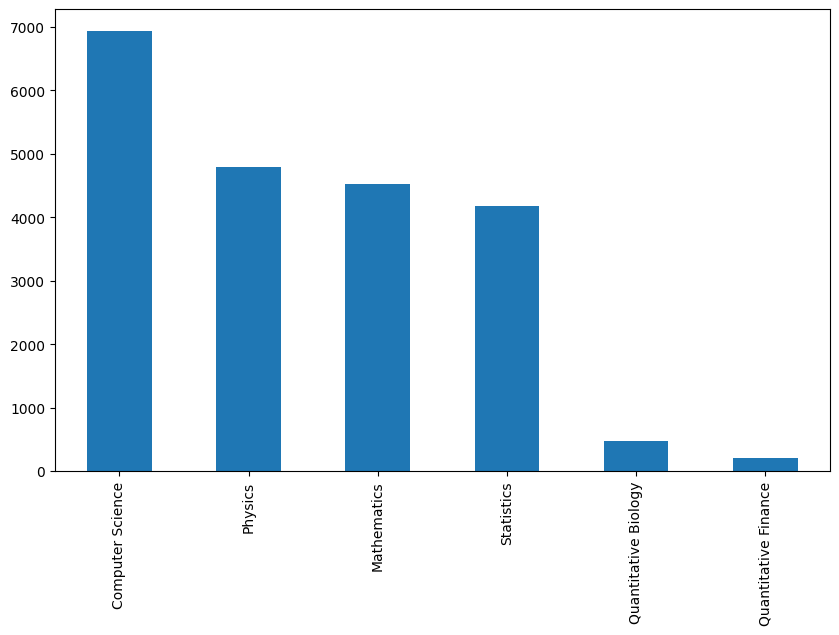

In [13]:
y_data = train_df[target_cols]

plt.figure(figsize=(8,6))
y_data.sum(axis=0).plot.bar()
plt.show()

# Data preparation

### Concatenate 'TITLE' and 'ABSTRACT' columns into one 'TEXT' column and drop old ones.

In [15]:
train_df['TEXT'] = train_df['TITLE'] + train_df['ABSTRACT']
train_df.drop(['TITLE', 'ABSTRACT'], axis=1, inplace=True)
train_df.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,TEXT
0,0,0,1,1,0,0,Characterization of multivariate Bernoulli dis...
1,0,0,1,0,0,0,Distinction of representations via Bruhat-Tits...
2,0,1,0,0,0,0,"On the origin of the shallow and ""replica"" ban..."
3,1,0,0,1,0,0,Explaining Recurrent Neural Network Prediction...
4,0,0,0,1,0,0,Estimators of the correlation coefficient in t...


## Preprocess text data

In [14]:
class DataPreprocess:
  def __init__(self):
    self.filters = [
      strip_tags,
      strip_punctuation,
      strip_multiple_whitespaces,
      remove_stopwords,
    ]

  def __call__(self, doc):
    wnl = WordNetLemmatizer()
    try:
      cleanse_words = set(preprocess_string(doc, self.filters))
      filtered_words = set(wnl.lemmatize(word, "v") for word in cleanse_words)

      return " ".join(filtered_words)
    except TypeError as te:
      raise (TypeError("Not a valid data {}".format(te)))

In [16]:
train_df['Processed'] = train_df['TEXT'].apply(DataPreprocess())

In [17]:
train_df['Processed'][1]

'Distinction build p Jean memory Introductory representations 2017 pass simplify Chaire proof Volker 2016 away pedagogical modify Morlet article Heiermann Bruhat Contains Broussous This IMRN Tits P Dipendra 3140 François appear adic To group 11 3157 write Prasad Courtès 2014 loc representation Steinberg appendix treatmeant Proceedings Ed cit september'

## Feature extraction

In [17]:
def lsa_reduction(X_train, X_test, n_comp=120):
	svd = TruncatedSVD(n_components=n_comp)
	normalizer = Normalizer()

	lsa_pipe = Pipeline([("svd", svd), ("normalize", normalizer)]).fit(X_train)

	train_reduced = lsa_pipe.transform(X_train)
	test_reduced = lsa_pipe.transform(X_test)
	return train_reduced, test_reduced


def vectorize(vector, X_train, X_test):
	vector_fit = vector.fit(X_train)

	X_train_vec = vector_fit.transform(X_train)
	X_test_vec = vector_fit.transform(X_test)

	print("Vectorization is completed.")
	return X_train_vec, X_test_vec

In [18]:
def get_pipe(x_data, n_features=1048576):
  hasher = HashingVectorizer(ngram_range=(1, 2), n_features=n_features)
  tfidf_transformer = TfidfTransformer(use_idf=True)

  return Pipeline([("hash", hasher), ("tfidf", tfidf_transformer)]).fit(x_data)


def hash_vectorizer(X_train, X_test):
  pipe = get_pipe(X_train)
  x_train_tf = pipe.transform(X_train)
  x_test_tf = pipe.transform(X_test)

  return x_train_tf, x_test_tf

In [19]:
x_full_hashed = get_pipe(train_df['Processed'])
x_full_hashed = x_full_hashed.transform(train_df['Processed'])

In [23]:
x_full_hashed.data

array([-0.13637821,  0.05603976, -0.10158742, ...,  0.03877126,
       -0.13474974,  0.12217125])

In [24]:
x_full_hashed.shape

(13481, 1048576)

# Build a Model

## Basic model

In [20]:
svc_1 = SVC(class_weight='balanced')

orc_clf_1 = OneVsRestClassifier(estimator=svc_1)

In [21]:
svc_2 = LinearSVC(class_weight='balanced', dual='auto')

orc_clf_svm = OneVsRestClassifier(estimator=svc_2, n_jobs=-1)

In [22]:
lr = LogisticRegression(class_weight='balanced')

orc_clf_lr = OneVsRestClassifier(estimator=lr, n_jobs=-1)

In [23]:
rf = RandomForestClassifier(n_estimators=500,
                            class_weight='balanced',
                            min_samples_leaf=3)
orc_clf_rf = OneVsRestClassifier(estimator=rf, n_jobs=-1)

In [24]:
def train_loop(model):
  for target in target_cols:
    y = train_df[target]
    X_train, X_valid, y_train, y_test = train_test_split(
      x_full_hashed, y, test_size=0.2, shuffle=True, random_state=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    print(
      "Label: %s \n Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n"
      % (
        target,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average="micro"),
        recall_score(y_test, y_pred, average="micro"),
        f1_score(y_test, y_pred, average="micro"),
      )
    )

# Train results

In [26]:
train_loop(orc_clf_1)

Label: Computer Science 
 Accuracy: 0.863 	Precision: 0.863 	Recall: 0.863 	F1-Score: 0.863

Label: Physics 
 Accuracy: 0.931 	Precision: 0.931 	Recall: 0.931 	F1-Score: 0.931

Label: Mathematics 
 Accuracy: 0.900 	Precision: 0.900 	Recall: 0.900 	F1-Score: 0.900

Label: Statistics 
 Accuracy: 0.877 	Precision: 0.877 	Recall: 0.877 	F1-Score: 0.877

Label: Quantitative Biology 
 Accuracy: 0.971 	Precision: 0.971 	Recall: 0.971 	F1-Score: 0.971

Label: Quantitative Finance 
 Accuracy: 0.990 	Precision: 0.990 	Recall: 0.990 	F1-Score: 0.990



In [32]:
train_loop(orc_clf_svm)

Label: Computer Science 
 Accuracy: 0.873 	Precision: 0.873 	Recall: 0.873 	F1-Score: 0.873

Label: Physics 
 Accuracy: 0.933 	Precision: 0.933 	Recall: 0.933 	F1-Score: 0.933

Label: Mathematics 
 Accuracy: 0.895 	Precision: 0.895 	Recall: 0.895 	F1-Score: 0.895

Label: Statistics 
 Accuracy: 0.888 	Precision: 0.888 	Recall: 0.888 	F1-Score: 0.888

Label: Quantitative Biology 
 Accuracy: 0.971 	Precision: 0.971 	Recall: 0.971 	F1-Score: 0.971

Label: Quantitative Finance 
 Accuracy: 0.989 	Precision: 0.989 	Recall: 0.989 	F1-Score: 0.989



In [33]:
train_loop(orc_clf_lr)

Label: Computer Science 
 Accuracy: 0.863 	Precision: 0.863 	Recall: 0.863 	F1-Score: 0.863

Label: Physics 
 Accuracy: 0.929 	Precision: 0.929 	Recall: 0.929 	F1-Score: 0.929

Label: Mathematics 
 Accuracy: 0.885 	Precision: 0.885 	Recall: 0.885 	F1-Score: 0.885

Label: Statistics 
 Accuracy: 0.868 	Precision: 0.868 	Recall: 0.868 	F1-Score: 0.868

Label: Quantitative Biology 
 Accuracy: 0.973 	Precision: 0.973 	Recall: 0.973 	F1-Score: 0.973

Label: Quantitative Finance 
 Accuracy: 0.991 	Precision: 0.991 	Recall: 0.991 	F1-Score: 0.991



In [34]:
train_loop(orc_clf_rf)

Label: Computer Science 
 Accuracy: 0.847 	Precision: 0.847 	Recall: 0.847 	F1-Score: 0.847

Label: Physics 
 Accuracy: 0.920 	Precision: 0.920 	Recall: 0.920 	F1-Score: 0.920

Label: Mathematics 
 Accuracy: 0.869 	Precision: 0.869 	Recall: 0.869 	F1-Score: 0.869

Label: Statistics 
 Accuracy: 0.834 	Precision: 0.834 	Recall: 0.834 	F1-Score: 0.834

Label: Quantitative Biology 
 Accuracy: 0.969 	Precision: 0.969 	Recall: 0.969 	F1-Score: 0.969

Label: Quantitative Finance 
 Accuracy: 0.987 	Precision: 0.987 	Recall: 0.987 	F1-Score: 0.987



## Select best performing models

In [37]:
hashing_features_list = [25000, 50000, 100000, 500000, 1048576, 2097152]

In [49]:
def train_loop_2(model, label):
  for n_features in hashing_features_list:
    pipe = get_pipe(train_df["Processed"], n_features=n_features)
    x = pipe.transform(train_df["Processed"])

    X_train, X_valid, y_train, y_test = train_test_split(
      x, train_df[label], test_size=0.2
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    print(
      "Label: %s \t n_features: %d \t Accuracy: %1.3f"
      % (label, n_features, accuracy_score(y_test, y_pred))
    )

### 'Computer Science' LinearSVC has best accuracy = 0.873

In [24]:
linear_svc_2 = LinearSVC(class_weight='balanced', dual='auto')
svc_computer_science = OneVsRestClassifier(estimator=linear_svc_2, n_jobs=-1)

In [38]:
train_loop_2(svc_computer_science, 'Computer Science')

Label: Computer Science 	 n_features: 25000 	 Accuracy: 0.843
Label: Computer Science 	 n_features: 50000 	 Accuracy: 0.861
Label: Computer Science 	 n_features: 100000 	 Accuracy: 0.867
Label: Computer Science 	 n_features: 500000 	 Accuracy: 0.869
Label: Computer Science 	 n_features: 1048576 	 Accuracy: 0.870
Label: Computer Science 	 n_features: 2097152 	 Accuracy: 0.872


### 'Physics' LinearSVC has best accuracy = 0.933

In [28]:
linear_svc_3 = LinearSVC(class_weight='balanced', dual='auto')
svm_physics = OneVsRestClassifier(estimator=linear_svc_3, n_jobs=-1)

In [100]:
train_loop_2(svm_physics, 'Physics')

Label: Physics 	 n_features: 25000 	 Accuracy: 0.930
Label: Physics 	 n_features: 50000 	 Accuracy: 0.931
Label: Physics 	 n_features: 100000 	 Accuracy: 0.934
Label: Physics 	 n_features: 500000 	 Accuracy: 0.940
Label: Physics 	 n_features: 1048576 	 Accuracy: 0.942
Label: Physics 	 n_features: 2097152 	 Accuracy: 0.939


### 'Mathematics' LinearSVC has the best accuracy = 0.895

In [55]:
linear_svc_math = LinearSVC(class_weight='balanced', dual='auto')
svm_mathematics = OneVsRestClassifier(estimator=linear_svc_math, n_jobs=-1)

In [56]:
train_loop_2(svm_mathematics, 'Mathematics')

Label: Mathematics 	 n_features: 25000 	 Accuracy: 0.888
Label: Mathematics 	 n_features: 50000 	 Accuracy: 0.895
Label: Mathematics 	 n_features: 100000 	 Accuracy: 0.894
Label: Mathematics 	 n_features: 500000 	 Accuracy: 0.913
Label: Mathematics 	 n_features: 1048576 	 Accuracy: 0.903
Label: Mathematics 	 n_features: 2097152 	 Accuracy: 0.908


### 'Statistics' LinearSVC has best accuracy = 0.888

In [30]:
linear_svc_4 = LinearSVC(class_weight='balanced', dual='auto')
svm_statistics = OneVsRestClassifier(estimator=linear_svc_4, n_jobs=-1)

In [101]:
train_loop_2(svm_statistics, 'Statistics')

Label: Statistics 	 n_features: 25000 	 Accuracy: 0.873
Label: Statistics 	 n_features: 50000 	 Accuracy: 0.873
Label: Statistics 	 n_features: 100000 	 Accuracy: 0.883
Label: Statistics 	 n_features: 500000 	 Accuracy: 0.895
Label: Statistics 	 n_features: 1048576 	 Accuracy: 0.883
Label: Statistics 	 n_features: 2097152 	 Accuracy: 0.891


### 'Quantitative Biology' LogisticRegression has the best accuracy = 0.973

In [102]:
lr_bio_clf = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_biology = OneVsRestClassifier(estimator=lr_bio_clf, n_jobs=-1)

In [65]:
# default solver
train_loop_2(lr_biology, 'Quantitative Biology')

Label: Quantitative Biology 	 n_features: 25000 	 Accuracy: 0.971
Label: Quantitative Biology 	 n_features: 50000 	 Accuracy: 0.973
Label: Quantitative Biology 	 n_features: 100000 	 Accuracy: 0.971
Label: Quantitative Biology 	 n_features: 500000 	 Accuracy: 0.970
Label: Quantitative Biology 	 n_features: 1048576 	 Accuracy: 0.973
Label: Quantitative Biology 	 n_features: 2097152 	 Accuracy: 0.974


In [103]:
# solver='liblinear' slightly better results
train_loop_2(lr_biology, 'Quantitative Biology')

Label: Quantitative Biology 	 n_features: 25000 	 Accuracy: 0.972
Label: Quantitative Biology 	 n_features: 50000 	 Accuracy: 0.975
Label: Quantitative Biology 	 n_features: 100000 	 Accuracy: 0.977
Label: Quantitative Biology 	 n_features: 500000 	 Accuracy: 0.974
Label: Quantitative Biology 	 n_features: 1048576 	 Accuracy: 0.974
Label: Quantitative Biology 	 n_features: 2097152 	 Accuracy: 0.975


### 'Quantitative Finance' LogisticRegression has the best accuracy = 0.991

In [81]:
lr_fin_clf = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_finance = OneVsRestClassifier(estimator=lr_fin_clf, n_jobs=-1)

In [97]:
train_loop_2(lr_finance, 'Quantitative Finance')

Label: Quantitative Finance 	 n_features: 25000 	 Accuracy: 0.988
Label: Quantitative Finance 	 n_features: 50000 	 Accuracy: 0.991
Label: Quantitative Finance 	 n_features: 100000 	 Accuracy: 0.993
Label: Quantitative Finance 	 n_features: 500000 	 Accuracy: 0.993
Label: Quantitative Finance 	 n_features: 1048576 	 Accuracy: 0.992
Label: Quantitative Finance 	 n_features: 2097152 	 Accuracy: 0.994


## Stacking models

In [35]:
def get_stacking():
  level0 = []
  level0.append(('lr', orc_clf_lr))
  level0.append(('svm', orc_clf_svm))
  level0.append(('rf', orc_clf_rf))
  level1 = LogisticRegression()
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
  return model

In [36]:
def get_models():
  models = {}
  models['lr'] = orc_clf_lr
  models['svm'] = orc_clf_svm
  models['rf'] = orc_clf_rf
  models['stacking'] = get_stacking()
  return models

In [37]:
def evaluate_model(model, X, y):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  return scores

In [104]:
x_full_hashed.shape, train_df['Physics'].shape

((13481, 1048576), (16851,))

In [38]:
results, names = [], []
models = get_models()

for target in target_cols:
  y = train_df[target]
  for name, model in models.items():
    print(f"getting predictions for label: {target}, model: {name}")
    scores = evaluate_model(model, x_full_hashed, y)
    results.append(scores)
    names.append(f"{target}_{name}")
    print(
        "---%s %.3f (%.3f)" % (f"{target}_{name}", np.mean(scores), np.std(scores))
    )

plt.boxplot(results, labels=names, showmeans=True)
plt.show()
# this was stopped manually, because took too long and
# was giving worse results than single models

getting predictions for label: Computer Science, model: lr
---Computer Science_lr 0.859 (0.008)
getting predictions for label: Computer Science, model: svm
---Computer Science_svm 0.866 (0.006)
getting predictions for label: Computer Science, model: rf
---Computer Science_rf 0.835 (0.010)
getting predictions for label: Computer Science, model: stacking
---Computer Science_stacking 0.866 (0.007)
getting predictions for label: Physics, model: lr
---Physics_lr 0.931 (0.006)
getting predictions for label: Physics, model: svm
---Physics_svm 0.936 (0.006)
getting predictions for label: Physics, model: rf
---Physics_rf 0.925 (0.007)
getting predictions for label: Physics, model: stacking
---Physics_stacking 0.937 (0.006)
getting predictions for label: Mathematics, model: lr
---Mathematics_lr 0.895 (0.008)
getting predictions for label: Mathematics, model: svm
---Mathematics_svm 0.906 (0.007)
getting predictions for label: Mathematics, model: rf
---Mathematics_rf 0.870 (0.008)
getting predicti

KeyboardInterrupt: 

# inference

In [107]:
pipe = get_pipe(train_df["Processed"], n_features=2097152)
x = pipe.transform(train_df["Processed"])

pred_value = svc_computer_science.predict(x[5])
print(
    "Prediction: %d\nActual Y: %d\nText:\n%s"
    % (pred_value, train_df["Computer Science"][5], train_df["TEXT"][5])
)

Prediction: 1
Actual Y: 1
Text:
Deep Learning applied to Road Traffic Speed forecasting  In this paper, we propose deep learning architectures (FNN, CNN and LSTM) to
forecast a regression model for time dependent data. These algorithm's are
designed to handle Floating Car Data (FCD) historic speeds to predict road
traffic data. For this we aggregate the speeds into the network inputs in an
innovative way. We compare the RMSE thus obtained with the results of a simpler
physical model, and show that the latter achieves better RMSE accuracy. We also
propose a new indicator, which evaluates the algorithms improvement when
compared to a benchmark prediction. We conclude by questioning the interest of
using deep learning methods for this specific regression task.



# Save models to file

In [108]:
import pickle

In [109]:
svmcs_file = open('./models/svc_computer_science.pkl', 'wb')
pickle.dump(svc_computer_science, svmcs_file)
svmcs_file.close()

In [110]:
def save_model(model, filename):
    model_file = open(f"./models/{filename}.pkl", 'wb')
    pickle.dump(model, model_file)
    model_file.close()

In [111]:
save_model(svm_physics, 'svm_physics')
save_model(svm_mathematics, 'svm_mathematics')
save_model(svm_statistics, 'svm_statistics')
save_model(lr_biology, 'lr_biology')
save_model(lr_finance, 'lr_finance')